## SYNTHETIC LIGHT CURVE PCA ANALYSIS

##### Creating spectra
- create a spectra conforming to S' = S + c1(t) x S1 + c2(t) x S2

##### Simulate PANDORA Spectra
- Use PANDORA Sim

##### Do Principal Component Analysis on data
- Extract c1, c2, plot

### PANDORA BINNING AND ADDING NOISE TO SPECTRA.

        wave  transit_depth       err  fractional_error
0   0.900000       1.000000  0.037566          0.037566
1   0.911725       0.897451  0.040765          0.045423
2   0.923775       0.915489  0.040737          0.044498
3   0.936159       0.960405  0.037304          0.038842
4   0.948889       0.948195  0.036973          0.038993
5   0.961975       0.959903  0.035955          0.037457
6   0.975428       0.977066  0.033877          0.034672
7   0.989256       0.999066  0.032295          0.032326
8   1.003471       0.955274  0.033101          0.034651
9   1.018080       0.940810  0.032948          0.035021
10  1.033092       0.862695  0.035996          0.041725
11  1.048514       0.973086  0.030685          0.031534
12  1.064352       0.909805  0.032682          0.035922
13  1.080610       0.976051  0.029738          0.030468
14  1.097291       0.941285  0.030247          0.032133
15  1.114397       0.908161  0.030842          0.033961
16  1.131927       0.939451  0.029414          0

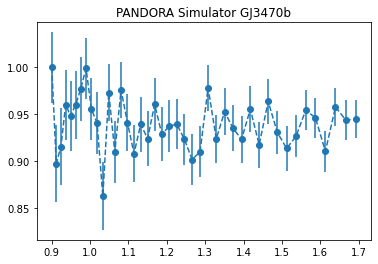

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.interpolate import interp1d
np.random.seed(120)

import os
from os.path import join
array = os.path.abspath('').split('/')
homedir = '/'
for i in range(1,7):
   homedir = join(homedir, array[i])
homedir

data_path = '~/Documents/GitHub/polar_vortice/polar_vortice/data/processed/luhman_16ab_sector36-37_longPeriodsRemoved_wd20hr.txt'
dataRaw = pd.read_csv(data_path, header=0, delimiter='\t')
plotPath = join(homedir, 'plots')

%matplotlib inline

## Use 2M3139 sample spectra from Apai 2013
header = ['x', 'y']
unbinfilename = '/Users/nguyendat/Documents/GitHub/polar_vortice/polar_vortice/data/sm3139_spectra_reduced.csv'
spectra_unbinned = pd.read_csv(unbinfilename, names=header)

## Plot sample simulated spectra of GJ 3470b
pandoraspecfilename = '/Users/nguyendat/Documents/GitHub/polar_vortice/polar_vortice/data/pandora-simSpec-gj3470b.csv'
gj3470b = pd.read_csv(pandoraspecfilename, names=['wave', 'transit_depth', 'err'], skiprows=1)
gj3470b.err = gj3470b.err/gj3470b.transit_depth
gj3470b.transit_depth = gj3470b.transit_depth/np.max(gj3470b.transit_depth)
gj3470b['fractional_error'] = gj3470b.err/gj3470b.transit_depth
plt.close(), plt.figure(), plt.title('PANDORA Simulator GJ3470b')
plt.errorbar(gj3470b.wave, gj3470b.transit_depth, yerr=gj3470b['err'], marker='o', ls='--')
print(gj3470b)

## Interpolate 2M3139 spectra to PANDORA resolution, add noise
interp2M3139 = interp1d(spectra_unbinned.x, spectra_unbinned.y, kind='cubic')
interpError = interp1d(gj3470b.wave, gj3470b.err, kind='cubic')
xbin = gj3470b.query('wave > 1.1').wave
ybin = interp2M3139(xbin)
spectra = pd.DataFrame()
spectra['x'], spectra['y'], spectra['err'] = xbin, ybin + 0.05*np.random.rand(), interpError(xbin)*4
# plt.close(), plt.figure(dpi=100), plt.title('PANDORA Simulator, 2M3139 Binned')
# plt.errorbar(spectra.x, spectra.y, yerr=spectra['err'], marker='o', ls='--')
# print(spectra)

### Creating spectra

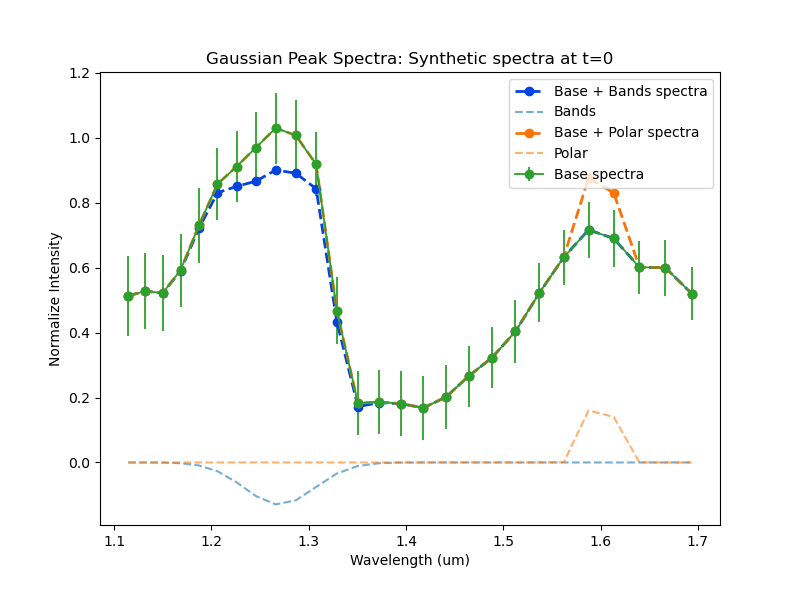

Photometry 1.1-1.7um : Base: 0.323, Base+polar: 0.331, Base+bands: 0.311


In [187]:
# filename = '/Users/nguyendat/Documents/GitHub/aroma/AROMA_An_Exo_Rot_Mapping/data/sm3139_spectra_reduced.csv'

# reduce = False
# if reduce:
#     spectra_raw = pd.read_csv(filename, names=header)
#     x0, y0 = spectra_raw.x.copy(), spectra_raw.y.copy()
#     ## Take every 2nd point of spectra array
#     spectra = pd.DataFrame(columns=header) 
#     skip = 3
#     spectra.x = x0[np.arange(0, len(x0), skip)]
#     spectra.y = y0[np.arange(0, len(y0), skip)]
#     print('original length: %i, new length: %i'%(len(x0), len(spectra.x)))
# else:
    # spectra = pd.read_csv(filename, names=header)

save = True
# save = False
    
plt.close(), 
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
ax.set_xlabel('Wavelength (um)'), ax.set_ylabel('Normalize Intensity')

## Treat bands and polar spectra as slopes
def polar_spectra_slope(lamda): return -0.7*lamda +2.2
def bands_spectra_slope(lamda): return +0.7*lamda +0.5

def polar_spectra_gaussian(lamda):
    mean = 1.6
    std = 1.1e-2
    return 0.3*np.exp(-(lamda - mean) ** 2 / (2 * std ** 2))

def bands_spectra_gaussian(lamda):
    mean = 1.27
    std = 3.6e-2
    return -0.13*np.exp(-(lamda - mean) ** 2 / (2 * std ** 2))

def polar_spectra_absorbslope(lamda):
    mean = 1.4
    std = 1e-2
    return -1.7 * ((0.2*np.exp(-(lamda - mean) ** 2 / (2 * std ** 2)))+1)*lamda + 2.5

def bands_spectra_absorbslope(lamda):
    mean = 1.4
    std = 1e-2
    return -1.4 * ((0.3*np.exp(-(lamda - mean) ** 2 / (2 * std ** 2)))+1)*lamda + 2.5

# type = 'slope'
type = 'gaussian'
# type = 'abs'

if type == 'slope':
    bandspec = bands_spectra_slope(spectra.x)
    polarspec = polar_spectra_slope(spectra.x)
    spectraType = 'Slopes'
elif type == 'gaussian':
    bandspec = bands_spectra_gaussian(spectra.x)
    polarspec = polar_spectra_gaussian(spectra.x) 
    spectraType = 'Gaussian Peak'
elif type == 'abs':
    bandspec = bands_spectra_absorbslope(spectra.x)
    polarspec = polar_spectra_absorbslope(spectra.x) 
    spectraType = 'Absorption'

ax.set_title('%s Spectra: Synthetic spectra at t=0'%(spectraType))
bands = spectra.y + bandspec
ax.plot(spectra.x, bands, label='Base + Bands spectra', c='xkcd:blue',ls='--', marker='o', ms=6, lw=2)
ax.plot(spectra.x, bandspec, label='Bands', ls='--', ms=6, lw=1.5, alpha=0.6)

polar = spectra.y + polarspec
ax.plot(spectra.x, polar, label='Base + Polar spectra', c='xkcd:orange',ls='--', marker='o', ms=6, lw=2)
ax.plot(spectra.x, polarspec, label='Polar', ls='--', ms=6, lw=1.5, alpha=0.6)

basespec = spectra.y
ax.errorbar(spectra.x, spectra.y, yerr=spectra.err, label='Base spectra',ls='-', lw=1.3, marker='o', ms=6) 
ax.legend(loc='upper right'), plt.show()

basephot = np.trapz(x=spectra.x, y=spectra.y)
polarphot = np.trapz(x=spectra.x, y=polar)
bandsphot = np.trapz(x=spectra.x, y=bands)

# ax.set_ylim(0.01,1.2)
print('Photometry 1.1-1.7um : Base: %.3f, Base+polar: %.3f, Base+bands: %.3f'%(basephot, polarphot, bandsphot))
# plt.show()

if save:
    plotOut = plotPath + '/[%s]spectra_at_t0'%type
    fig.savefig(plotOut+'.pdf', dpi=300, format='pdf', bbox_inches = 'tight')
    fig.savefig(plotOut+'.png', dpi=300, format='png', bbox_inches = 'tight')

### Generate variable spectras modulation with an arbitrary time array

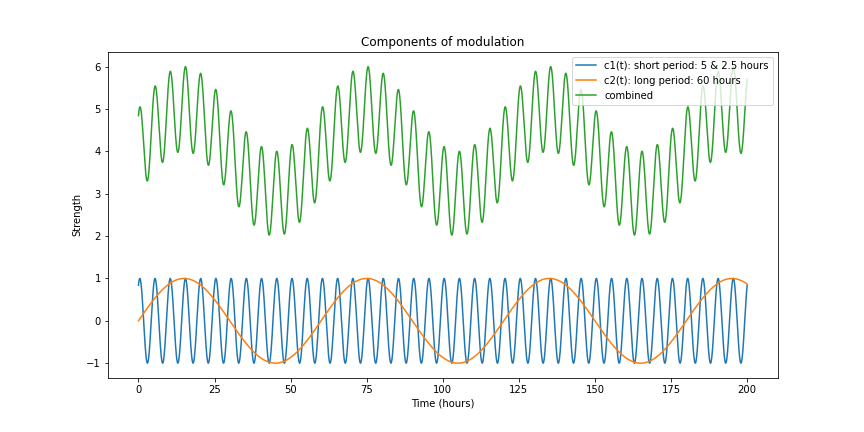

(<matplotlib.legend.Legend at 0x7fb0143e4220>, None)

In [161]:
## Generate variable spectras modulation with an arbitrary t
## c1: short period variation of 2.5 and 5 hours 

# def c1(t, a=0.5, p1=5, p2=2.5): 
#     return a*np.sin(2*np.pi/(p1)*t -0.3) + 2*a*np.sin(2*np.pi/(p2)*t + 1) # periods (hours)

def c1(t, a=1, period=5): return a*np.sin(2*np.pi/(period)*t+1) # periods (hours)
def c2(t, a=1, period=60): return a*np.sin(2*np.pi/(period)*t) # periods (hours)

t = np.linspace(0, 200, 5000)

plt.close(), plt.figure(figsize=(12,6)), 
plt.title('Components of modulation'),
plt.plot(t, c1(t), label='c1(t): short period: 5 & 2.5 hours'),  
plt.plot(t, c2(t), label='c2(t): long period: 60 hours'),
plt.plot(t, c1(t) + c2(t)+4, label='combined'),
plt.xlabel('Time (hours)'), plt.ylabel('Strength'),
plt.legend(), plt.show()

#### Now actually generate PANDORA-timesteps array based on observation visit schedule

**** Generating PANDORA timepoint with 
3 visits, 
50 hours between visits, 
16 orbit_per_visit,
95.0 min per orbit, 
50.0 min of target visibility, 
2.0 min cadence
**** Assume visit spacing is 50 hours
**** Generating n=1200 time points for baseline of 176 hours
**** Length: 1200 time points


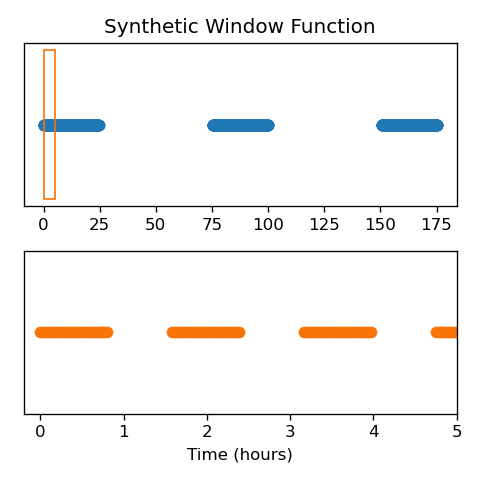

In [162]:
## Generate PANDORA-timesteps
## Assume cadence = intergration = 120 seconds 
## visits =  3 visits, each visit 16 orbits; 
## each orbit is 95 minutes 
## with 45 minutes without target visibility

# save = True
save = False

def pandora_window(visit=3, orbit_per_visit=16, cadence=2, time_per_orbit=95, visibility_time=50, 
                   visit_spacing = 50, output='hour'):
    # cadence and visibility_time: unit is minutes
    # assume visit spacing in hours
    
    print('**** Generating PANDORA timepoint with \n%i visits, \n%i hours between visits, \n%i orbit_per_visit,\
\n%.1f min per orbit, \n%.1f min of target visibility, \n%.1f min cadence'%(
    visit, visit_spacing, orbit_per_visit, time_per_orbit, visibility_time, cadence))
    print('**** Assume visit spacing is %i hours'%(visit_spacing))
    
    invisibility_time = time_per_orbit-visibility_time
    
    if output == 'hour':
        # convert t to hours
        time_per_orbit/=60
        visibility_time/=60
        cadence/=60
        invisibility_time/=60

    n_per_orbit = int(visibility_time/cadence)
    n = int(n_per_orbit * orbit_per_visit * visit)
    baseline = time_per_orbit * orbit_per_visit * visit + (visit-1) * visit_spacing
    print('**** Generating n=%i time points for baseline of %i hours'%(n, baseline))
    
    time_step = []
    for i in range(n):
        value = 0
        if i == 0:
            time_step.append((i, value))
        else:
            if i%400 == 0: value += visit_spacing
            if i%n_per_orbit == 0: value+=invisibility_time
            value += (time_step[-1][1] + cadence)
            
            time_step.append((i, value))
            
    return time_step, n

tsim, n = pandora_window()

from matplotlib.patches import Rectangle
plt.close(), 
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(4,4), dpi=120)
ax1.set_title('Synthetic Window Function')

# create rectangle
rect = Rectangle((0, -1), 5, 2, linewidth=1, edgecolor='xkcd:orange', facecolor='none')
# Add the patch to the current axes
ax1.add_patch(rect)

ax1.scatter(np.array(tsim)[:,1], np.zeros(len(tsim)))
ax1.set_yticks([])

ax2.scatter(np.array(tsim)[:,1], np.zeros(len(tsim)), c='xkcd:orange')
ax2.set_yticks([])
ax2.set_xlim((-0.2, 5))
ax2.set_xlabel('Time (hours)'), plt.tight_layout()
print('**** Length: %i time points'%(len(tsim)))

if save:
    plotOut = plotPath + '/synthetic_window_function'
    fig.savefig(plotOut+'.pdf', dpi=300, format='pdf', bbox_inches = 'tight')
    fig.savefig(plotOut+'.png', dpi=300, format='png', bbox_inches = 'tight')

#### Let's generate Pandora-observation-like time-step array

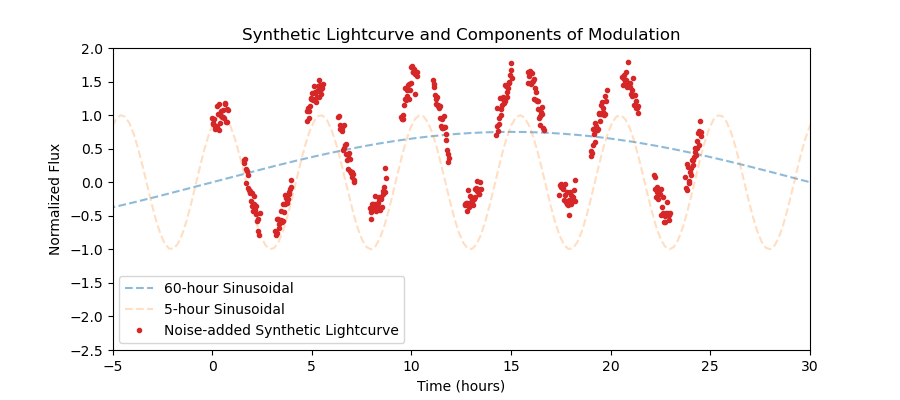

In [163]:
## Generate variable spectras modulation with simulate PANDORA timestep
## c1: short period variation of 2.5 and 5 hours 

# def c1(t, a=0.5, p1=5, p2=2.5): 
#     return a*np.sin(2*np.pi/(p1)*t -0.3) + 2*a*np.sin(2*np.pi/(p2)*t + 1) # periods (hours)
# save = True
save = False

%matplotlib widget

def c1(t, a=1, period=5): return a*np.sin(2*np.pi/(period)*t+1) # periods (hours)
def c2(t, a=0.75, period=60): return a*np.sin(2*np.pi/(period)*t) # periods (hours)

t = np.array(tsim)[:,1].copy()
tsyn = np.linspace(-20, 200, 1000)
noise_array = 0.1*np.random.randn(t.shape[0])

plt.close()
fig, ax = plt.subplots(figsize=(9,4), dpi=100)
ax.set_title('Synthetic Lightcurve and Components of Modulation'),
# plt.plot(t, c1(t), label='c1(t): short period: 5', ls='', marker='o', ms=2),  
# plt.plot(t, c2(t)-3, label='c2(t): long period: 60 hours', ls='', marker='o', ms=2),

synthetic_lightcurve = c1(t) + c2(t) + noise_array 

ax.plot(tsyn, c2(tsyn), alpha=0.5, ls='--', c='tab:blue', label='60-hour Sinusoidal'),
ax.plot(tsyn, c1(tsyn), alpha=0.25, ls='--', c='tab:orange', label='5-hour Sinusoidal'),
ax.plot(t, synthetic_lightcurve, label='Noise-added Synthetic Lightcurve', ls='', marker='o', ms=3, c='tab:red'),

ax.set_xlabel('Time (hours)'), plt.ylabel('Normalized Flux'),
ax.set_xlim(-5, 30)
ax.set_ylim(-2.5, 2)
ax.legend()

if save:
    plotOut = plotPath + '/synthetic_lightcurves'
    fig.savefig(plotOut+'.pdf', dpi=300, format='pdf', bbox_inches = 'tight')
    fig.savefig(plotOut+'.png', dpi=300, format='png', bbox_inches = 'tight')

### GENERATE PANDORA SPECTRAL CUBE

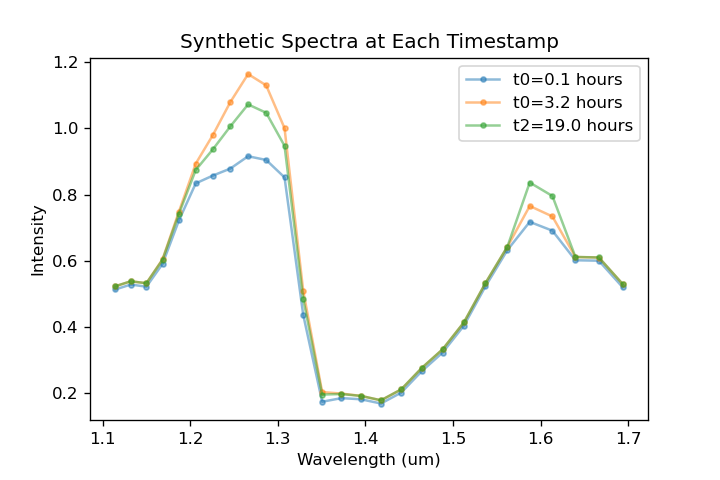

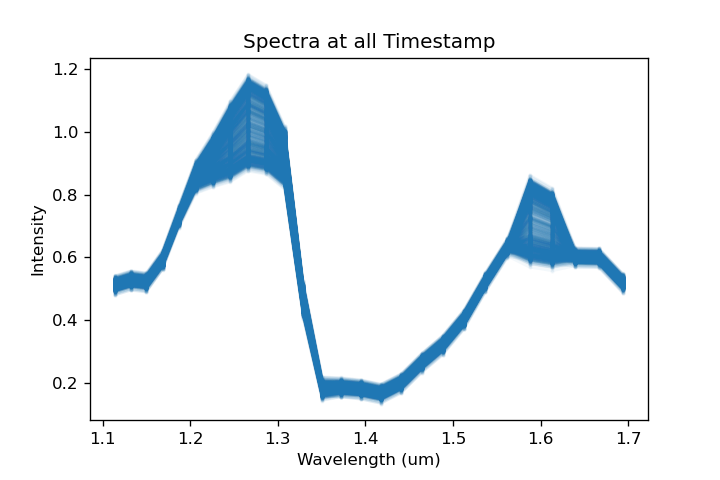

In [182]:
# save = True
save = False

## Generate a modulated spectra
lam = np.array(spectra.x)
dataTable = [lam]
spectraCube2 = []
spectraCube, spectraCubeNoTime = [], []
noiseAddition = 0.01*np.random.randn(t.shape[0])

for i,timestep in enumerate(t): 
    modulatedSpectra = np.array(basespec+ c1(timestep)*bandspec + c2(timestep)*polarspec + noiseAddition[i])
    time = timestep * np.ones(len(lam))
    spectraCube.append((timestep, (lam, modulatedSpectra)))
    # print(table0)
    table0 = (time, lam, modulatedSpectra)
    for i,lamda in enumerate(lam):
        spectraCube2.append((time[i], lamda, modulatedSpectra[i]))
    spectraCubeNoTime.append((lam, modulatedSpectra))
    dataTable.append(modulatedSpectra)
dataTable = np.transpose(dataTable)
    
# Convert to np.array
spectraCubeNoTime = np.array(spectraCubeNoTime)
    
spec002 = spectraCube[2]
spec050 = spectraCube[50]
# spec200 = spectraCube[200]
spec400 = spectraCube[300]

plt.close(), 
fig, ax = plt.subplots(figsize=(6,4), dpi=120)
ax.plot(spec002[1][0], spec002[1][1], label='t0=%.1f hours'%(spec002[0]), ls='-', marker='.', ms=6, alpha=0.5)
ax.plot(spec050[1][0], spec050[1][1], label='t0=%.1f hours'%(spec050[0]), ls='-', marker='.', ms=6, alpha=0.5)
# plt.plot(spec200[1][0], spec200[1][1], label='t1=%.2f hours'%(spec200[0]), ls='-', marker='.', ms=6, alpha=0.5)
ax.plot(spec400[1][0], spec400[1][1], label='t2=%.1f hours'%(spec400[0]), ls='-', marker='.', ms=6, alpha=0.5)
ax.legend(), ax.set_xlabel('Wavelength (um)'), ax.set_ylabel('Intensity') 
ax.set_title('Synthetic Spectra at Each Timestamp')

f, axe = plt.subplots(figsize=(6,4), dpi=120)
axe.set_title('Spectra at all Timestamp')
for i in range(len(tsim)):
    specnum = spectraCube[i]
    axe.plot(specnum[1][0], specnum[1][1], ls='-', marker='.', ms=3, c='tab:blue', alpha=0.05)
axe.set_xlabel('Wavelength (um)'), axe.set_ylabel('Intensity')

if save:
    plotOut = plotPath + '/[%s]spectra_at_3_timestamp'%type
    fig.savefig(plotOut+'.pdf', dpi=300, format='pdf', bbox_inches = 'tight')
    fig.savefig(plotOut+'.png', dpi=300, format='png', bbox_inches = 'tight')

### PLOT THE PANDORA 3D SPECTRAL CUBE

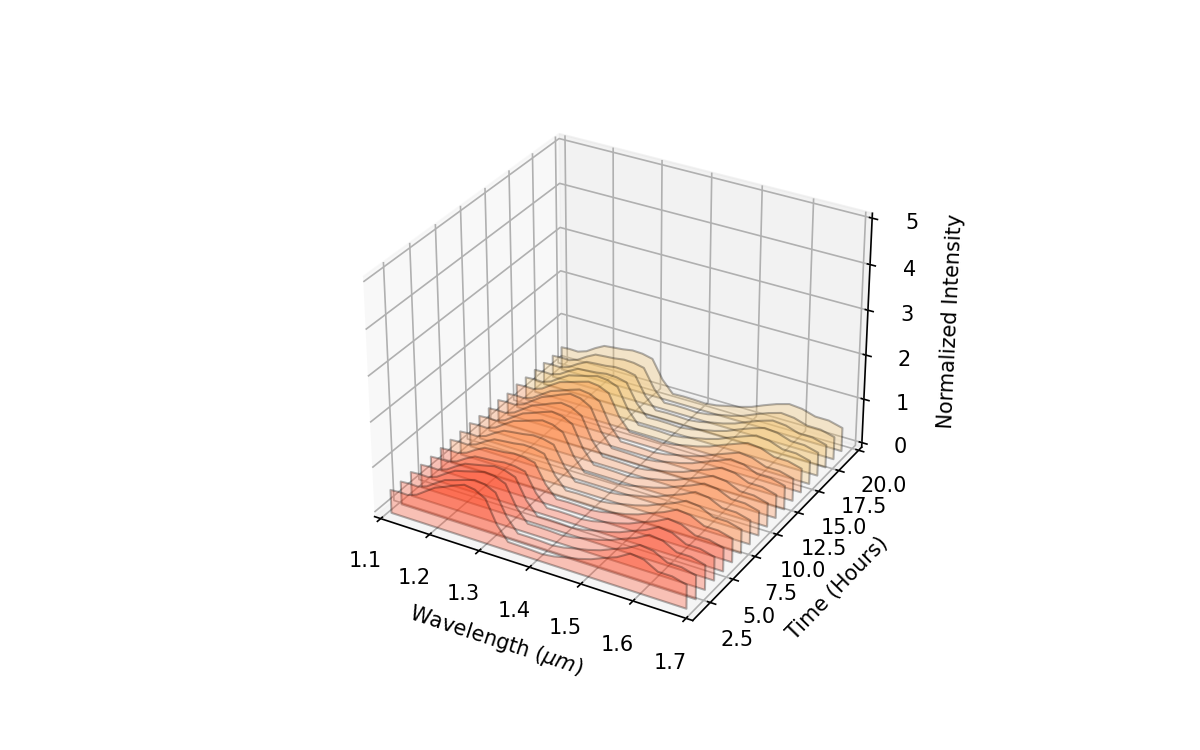

In [183]:
## PLOT 3D SPECTRAL CUBE

# save = True
save = False

from matplotlib.collections import PolyCollection
from matplotlib import cm
viridis = cm.get_cmap('rainbow_r', 12)

def polygon_under_graph(x, y):
    """
    Construct the vertex list which defines the polygon filling the space under
    the (x, y) line graph. This assumes x is in ascending order.
    """
    return [(x[0], 0.), *zip(x, y), (x[-1], 0.)]

ax = plt.figure(figsize=(8,5), dpi=150).add_subplot(projection='3d')
n= 20
skip=6
lambdas = range(1, n)

# verts[i] is a list of (x, y) pairs defining polygon i.
verts = [polygon_under_graph(spectraCube[i+skip*(i-1)][1][0], spectraCube[i+skip*(i-1)][1][1]) for i in lambdas]
facecolors = viridis(np.linspace(0.30, 0.1, len(verts)))

poly = PolyCollection(verts, facecolors=facecolors, edgecolors=("black"), alpha=0.3)
ax.add_collection3d(poly, zs=np.flip(lambdas), zdir='y')

ax.set(xlim=(1.1, 1.7), ylim=(1, n), zlim=(0, 5.0),
       xlabel=r'Wavelength $(\mu m)$', ylabel='Time (Hours)', zlabel='Normalized Intensity')
# ax.set_title('Synthetic Spectral Cube')
# plt.show()

if save:
    plotOut = plotPath + '/[%s]3d_spectral_cube'%type
    plt.savefig(plotOut+'.pdf', dpi=300, format='pdf', bbox_inches = 'tight')
    plt.savefig(plotOut+'.png', dpi=300, format='png', bbox_inches = 'tight')

(1201, 27)
(1201, 2)


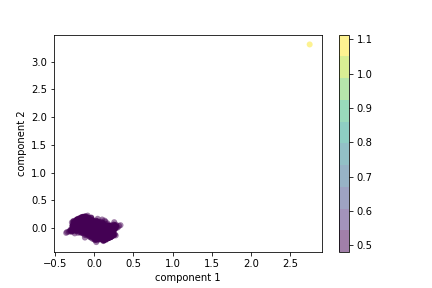

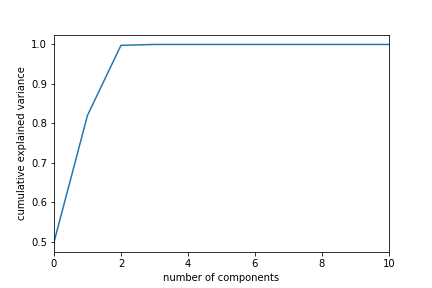

In [184]:
df = pd.DataFrame(np.transpose(dataTable))
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(df)
print(df.shape)
print(projected.shape)

plt.close(), plt.figure()
plt.scatter(projected[:, 0], projected[:, 1], c=df.iloc[:,0], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('viridis', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

pca = PCA().fit(df)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.xlim((0,10))
plt.ylabel('cumulative explained variance');


## Implement a PCA analysis

Relative variance in principal components: [0.49927806 0.32104158 0.17744194 0.00223842]
[ 2.74510781 -0.10264374 -0.12902909 ... -0.1601436  -0.22688995
 -0.21498203]
[3.30940473 0.11708902 0.10587516 ... 0.06241432 0.02445315 0.0350687 ]
[1.70048293 0.04911622 0.04248828 ... 0.1032067  0.08357939 0.0880168 ]
[ 0.12688153 -0.02071006 -0.01499085 ... -0.01433463  0.00236148
 -0.0014743 ]


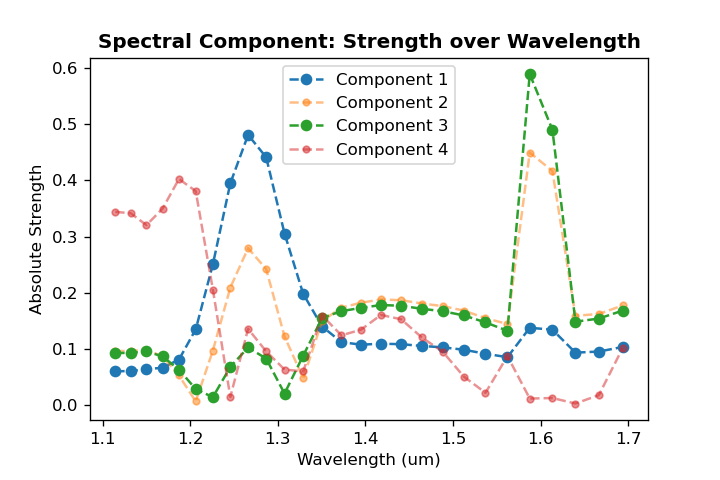

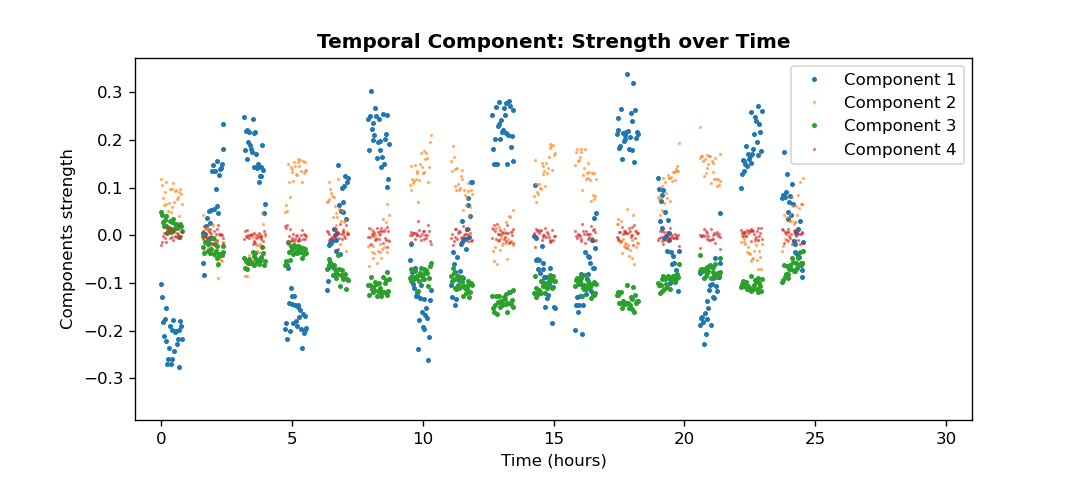

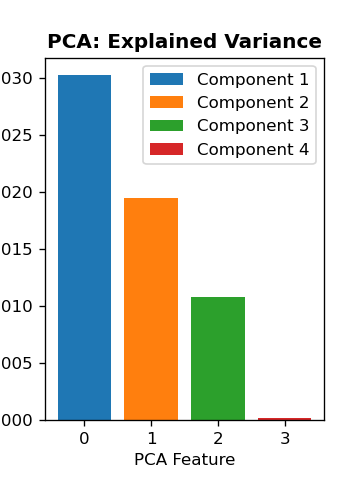

In [185]:
%matplotlib widget
## flatten the data
# X = np.transpose(dataTable) # already a 2D data format as required
# X = dataTable # already a 2D data format as required

# save = True
save = False

### implement a PCA with n_components
# if n_component > 1: choose n first-most-important component
# if n_component < 1: choose percertage value of component sum that preserves n% data variability
# pca = PCA(n_components=0.9999)
pca = PCA(n_components=4)
pca.fit(df)
X_pca = pca.transform(df)
# pca.components_

print("Relative variance in principal components:", pca.explained_variance_ratio_)

#########################################################################
#### SPECTRAL COMPONENT PLOT
color = {}
fig1, ax1 = plt.subplots(figsize=(6,4),dpi=120)
ax1.set_title('Spectral Component: Strength over Wavelength', weight='bold')
for i, comp in enumerate(pca.components_):
    if type == 'gaussian':
        y = comp
    else:
        y = -comp
    if i == 0 or i == 2:    
        g = ax1.plot(lam, np.abs(y), ls='--', marker='o', ms=6, lw=1.5, label='Component %i'%(i+1))
    else:
        g = ax1.plot(lam, np.abs(y), ls='--', marker='o', ms=4, lw=1.5, label='Component %i'%(i+1), alpha=0.5)
    ax1.set_xlabel('Wavelength (um)'), ax1.set_ylabel('Absolute Strength')
    ax1.legend()
    color[i] = g[0].get_color()
if save:
    plotOut = plotPath + '/[%s]PCA_SpectralCompPlot'%type
    fig1.savefig(plotOut+'.pdf', dpi=300, format='pdf', bbox_inches = 'tight')
    fig1.savefig(plotOut+'.png', dpi=300, format='png', bbox_inches = 'tight')
    
#########################################################################
#### TEMPORAL COMPONENT PLOT
fig2, ax2 = plt.subplots(figsize=(9,4),dpi=120)
ax2.set_title('Temporal Component: Strength over Time', weight='bold')
for i, comp in enumerate(np.transpose(X_pca)):
    print(comp)
    if i == 0 or i == 2:
        ax2.plot(t, comp[1:], ls='', marker='o', ms=2, lw=1, label='Component %i'%(i+1), c=color[i])
    else:
        ax2.plot(t, comp[1:], ls='', marker='o', ms=1, lw=1, label='Component %i'%(i+1), c=color[i], alpha=0.5)
    ax2.set_xlabel('Time (hours)'), ax2.set_ylabel('Components strength'), ax2.legend(loc='upper right')
    # if type == 'gaussian': plt.ylim((-1,1))
    # if type == 'gaussian': plt.ylim((-0.3,0.3))
    ax2.set_xlim((-1,31))
if save:
    plotOut = plotPath + '/[%s]PCA_TimeCompPlot'%type
    fig2.savefig(plotOut+'.pdf', dpi=300, format='pdf', bbox_inches = 'tight')
    fig2.savefig(plotOut+'.png', dpi=300, format='png', bbox_inches = 'tight')
    
#########################################################################
#### BAR PLOT: explained_variance
fig3, ax3 = plt.subplots(figsize=(3,4),dpi=120)
for i, variance in enumerate(pca.explained_variance_):
    ax3.bar(i,variance, label='Component %i'%(i+1), color=color[i])
ax3.set_xlabel('PCA Feature'), ax3.set_ylabel('Explained variance'), ax3.legend(loc='upper right')
ax3.set_title('PCA: Explained Variance', weight='bold')
if save:
    plotOut = plotPath + '/[%s]PCA_VarianceBarPlot'%type
    fig3.savefig(plotOut+'.pdf', dpi=300, format='pdf', bbox_inches = 'tight')
    fig3.savefig(plotOut+'.png', dpi=300, format='png', bbox_inches = 'tight')

[9] [22]


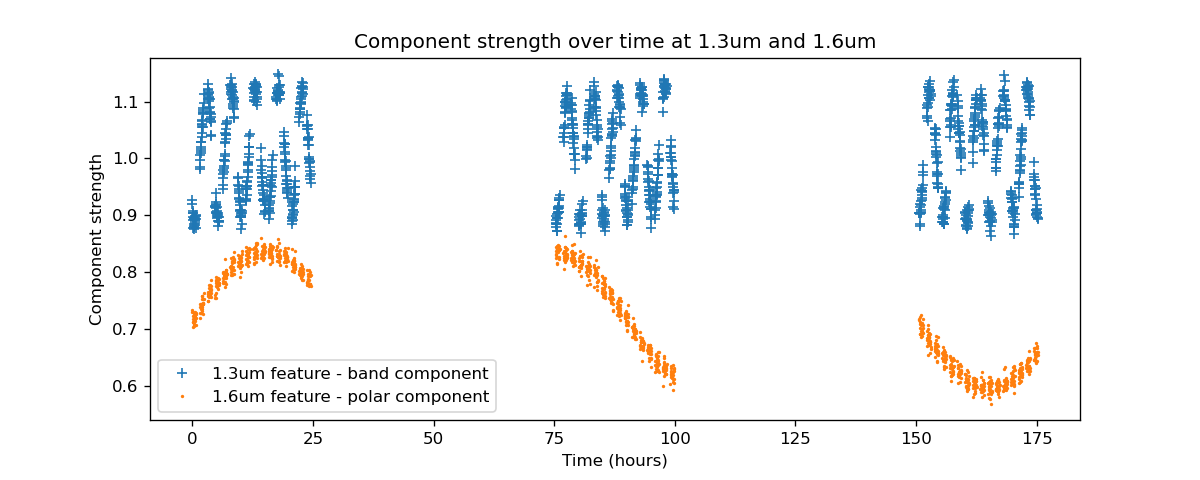

In [186]:
if type == 'gaussian':
    # a = np.where(np.logical_and(lam>1.29, lam<1.30))
    # b = np.where(np.logical_and(lam>1.595, lam<1.60))
    # c = np.where(np.logical_and(lam>1.39, lam<1.40))
    # print(a,b,c)
    
    a = np.where(np.logical_and(lam>1.28, lam<1.30))[0]
    b = np.where(np.logical_and(lam>1.58, lam<1.60))[0]
    print(a,b)

    df1 = df.iloc[:, a][1:].values
    df2 = df.iloc[:, b][1:].values

    plt.close()
    plt.figure(figsize=(10,4), dpi=120)
    plt.title('Component strength over time at 1.3um and 1.6um')
    
    plt.plot(t, df1, label='1.3um feature - band component', marker='+', ls='')
    plt.plot(t, df2, label='1.6um feature - polar component', marker='o', ls='', ms=1)
    
    plt.xlabel('Time (hours)'), plt.ylabel('Component strength')
    plt.legend()
    
else:
    print('Analysis not optimal for this type of spectral features')

In [180]:
if type == 'abs' or type == 'slope':
    %matplotlib widget
    # %matplotlib inline
    all = np.transpose(X_pca)
    
    for i,comp in enumerate(all):
        if i==0: 
            a=2
            targ = all[a, 1:]/np.max(all[a, 1:])
        elif i==1: 
            targ = all[0, 1:]/np.max(all[0, 1:]) + all[2, 1:]/np.max(all[2, 1:])
        elif i==2: 
            a=2
            
        targ = all[a, 1:]/np.max(all[a, 1:])
        
        y = comp[1:]/np.max(comp[1:])
        # print(comp, targ)
        plt.figure(figsize=(9,2),dpi=100)
        plt.title('Component %i'%i)
        plt.plot(t, (y-targ), ls='', marker='+', ms=6, lw=1, c=color[i]), 
        # plt.plot(t, (comp[1:]), ls='', marker='+', ms=6, lw=1, c=color[i]), 
        plt.xlabel('Time (hours)'), plt.ylabel('Components strength')
        plt.xlim(-3, 28), plt.ylim(-2,2.5)
else:
    print('Analysis not optimal for this type of spectral features')

Analysis not optimal for this type of spectral features
